In [1]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
import h5py
import torch
import pickle
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
model_checkpoint_save_dir = './models/checkpoints/'
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dtype)
print(device)

torch.float32
cuda:0


# Connect Colab and Google Drive

In [3]:
# Path to where deeplearningproject is stored on drive that contains the data and the git repo (may have to be changed depending on user)
# Note can just use Colab terminal with git commands to commit, pull, push, etc. (Note have to follow this to push: https://stackoverflow.com/a/65951928/14018615)
deep_learn_drive_path = '/content/drive/MyDrive/CS 6955/deeplearningproject/'
# To use with colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# cd into git repo
os.chdir(deep_learn_drive_path + 'cs-6955-deep-learning-final-project')
print('Git directory content: {0}'.format(os.listdir()))

Git directory content: ['porositydata_howto.py', '.git', 'README.md', 'models', 'porositydataset.hdf5', '.gitignore', 'PorousMaterialImageToYoungsModulusNet.ipynb', 'porositydataset_resized.hdf5', 'PorousMaterialImageAndStrainToStressNet.ipynb', 'porositydataset_2000runs.hdf5', 'rnn_torchviz', 'PorousMaterialImageToYoungsModulusNet_dkbirky.ipynb', 'PorousMaterialImageAndStrainToMaterialPropertiesNet.ipynb']


In [5]:
porosity_dataset_filename = 'porositydataset_2000runs.hdf5'
# porosity_dataset_filename = 'porositydataset.hdf5'

# Create PyTorch Dataset 

In [6]:
class PorousMaterialImageAndStrainToMaterialPropertiesDataset(Dataset):
    def __init__(self, hdf5_porosity_path, img_transform=None):
        self.img_transform = img_transform
        ##load the dataset
        self.d = h5py.File(hdf5_porosity_path,'a')
        #load original images
        self.og_images = np.zeros(self.d['Original Images'].shape)
        self.og_images[:,:,:] = self.d['Original Images']
        #load deformed images
        self.deformed_images = np.zeros(self.d['Deformed Images'].shape)
        self.deformed_images[:,:,:] = self.d['Deformed Images']
        #load stress-strain data
        self.ss_data = np.zeros(self.d['Data'].shape)
        self.ss_data[:,:,:] = self.d['Data']
        #separate stresses/strains, stresses in MPa, strain is unitless
        self.SMises = self.ss_data[:,0,:] #von Mises stress
        self.S11 = self.ss_data[:,1,:] #stress in 11 direction
        self.S22 = self.ss_data[:,2,:] #stress in 22 direction
        self.SP = self.ss_data[:,3,:] #pressure stress
        self.strain = self.ss_data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
        #load youngs moduli, units are GPa
        self.E = np.zeros(self.d['Youngs Modulus'].shape)
        self.E[:] = self.d['Youngs Modulus']
        
    def __len__(self):
        return self.E.size

    def __getitem__(self, idx):
        og_image_idx = self.og_images[idx,:,:,:].astype('uint8')
        deformed_image_idx = self.deformed_images[idx,:,:,:].astype('uint8')
        if (self.img_transform is not None):
            og_image_idx = self.img_transform(og_image_idx)
            deformed_image_idx = self.img_transform(deformed_image_idx)
        SMises_idx = self.SMises[idx,:]
        S11_idx = self.S11[idx,:]
        S22_idx = self.S22[idx,:]
        SP_idx = self.SP[idx,:]
        strain_idx = self.strain[idx,:]
        E_idx = self.E[idx]
        # Will be using og_images and strain to get SMises and E
        return og_image_idx, strain_idx, SMises_idx, E_idx

In [7]:
# Load porous dataset into memory
porous_dataset = PorousMaterialImageAndStrainToMaterialPropertiesDataset(porosity_dataset_filename, img_transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [8]:
# Split into train and test
test_prop = 0.2
test_size = int(test_prop*len(porous_dataset))
train_size = len(porous_dataset) - test_size
porous_train_dataset, porous_test_dataset = random_split(porous_dataset, (train_size, test_size)) 

# Split train into train and val
val_prop = 0.2
val_size = int(val_prop*len(porous_train_dataset))
train_size = len(porous_train_dataset) - val_size
porous_train_dataset, porous_val_dataset = random_split(porous_train_dataset, (train_size, val_size)) 

In [9]:
batch_size = 64
train_loader = DataLoader(porous_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(porous_test_dataset)
val_loader = DataLoader(porous_val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elastic Modulus = 196.82889047820987 GPa


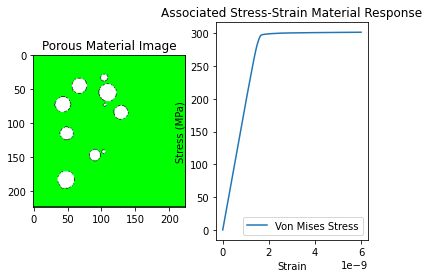

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 155.69163538452804 GPa


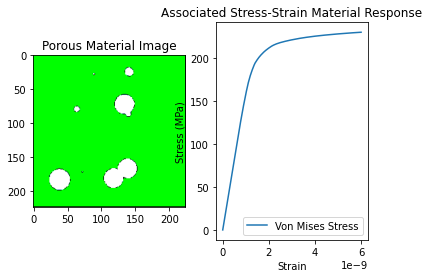

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 196.82889047820987 GPa


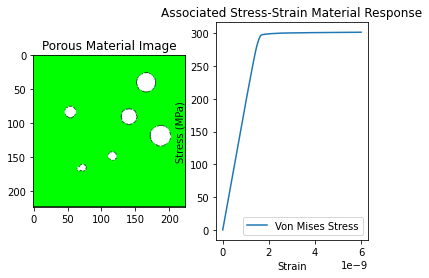

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 170.02409464400748 GPa


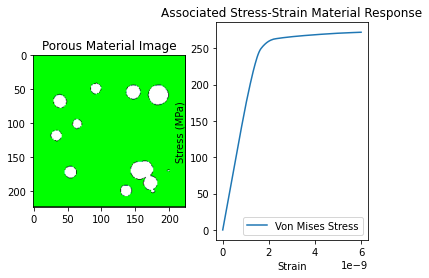

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 167.8835236715484 GPa


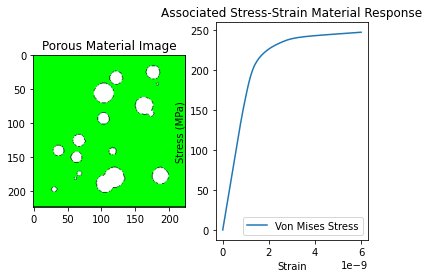

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 198.73067345644105 GPa


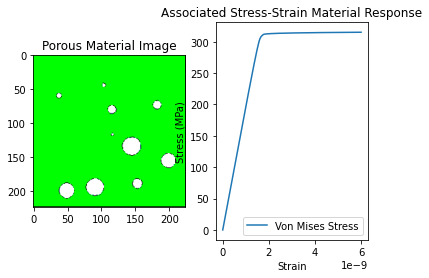

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 185.4336684879721 GPa


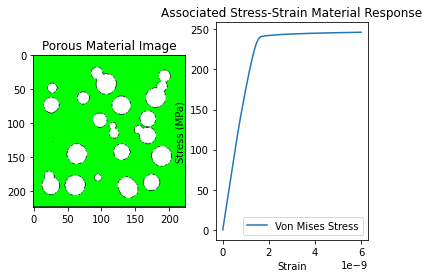

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 160.79001929758545 GPa


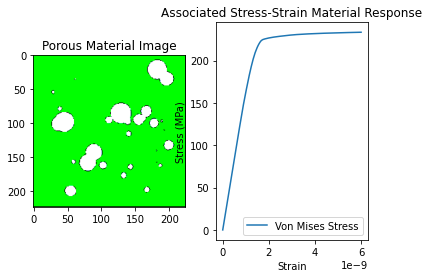

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 178.10433610978964 GPa


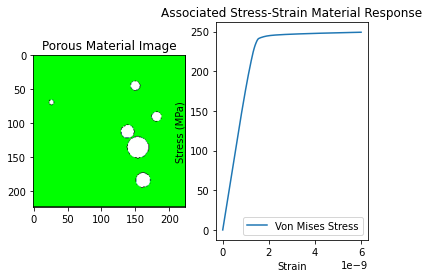

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 165.39211202625444 GPa


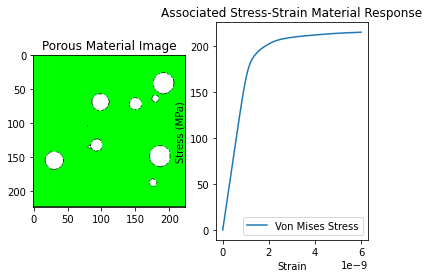

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 191.70920195091838 GPa


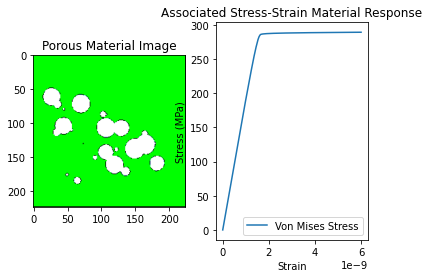

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 189.72556682144005 GPa


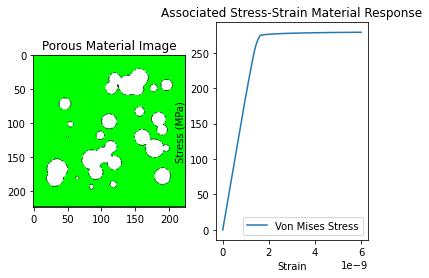

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 184.68714785606187 GPa


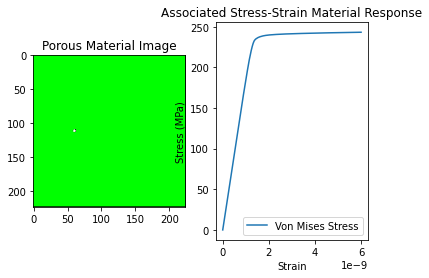

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 191.3120088640258 GPa


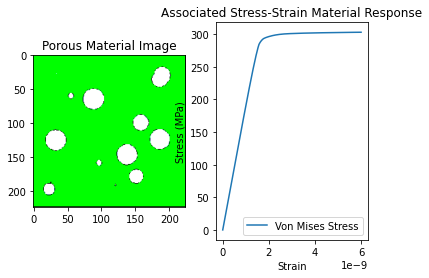

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 172.6917275091754 GPa


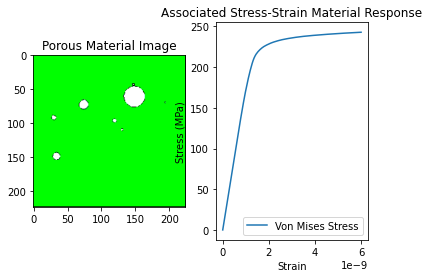

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 196.38037123362895 GPa


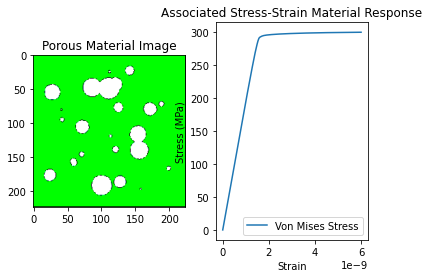

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 184.68714785606187 GPa


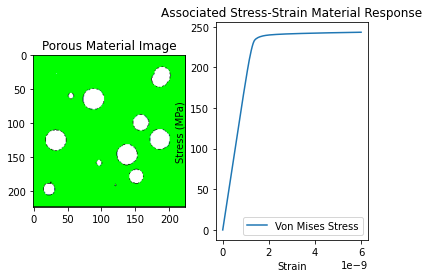

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 170.5464140863125 GPa


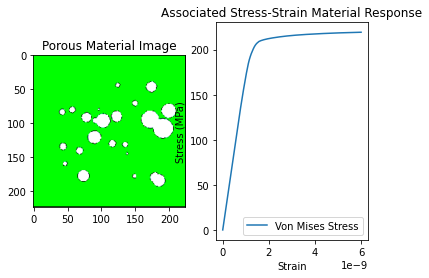

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 150.72293415473192 GPa


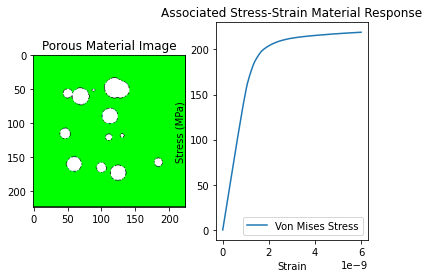

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 151.09089091818268 GPa


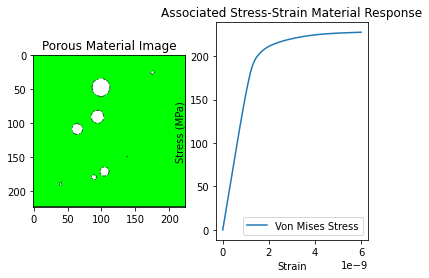

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 170.0080429785402 GPa


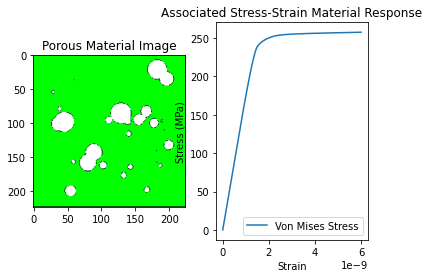

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 189.30543640383783 GPa


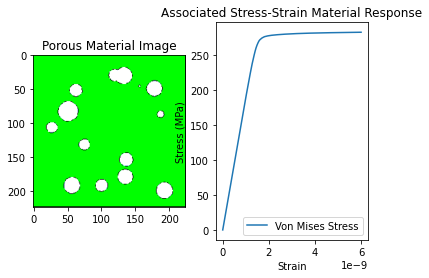

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 192.11587107760204 GPa


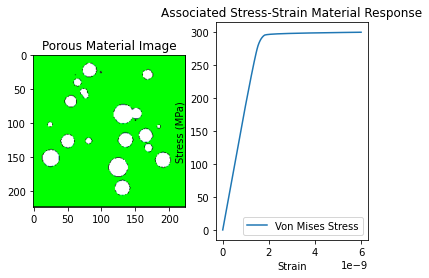

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 177.78429130176468 GPa


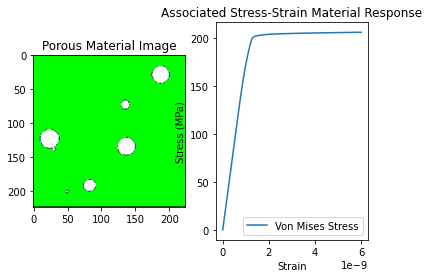

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 162.22917344593452 GPa


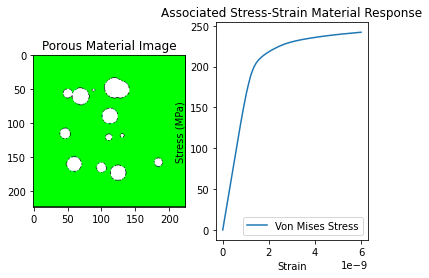

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 145.6966875328778 GPa


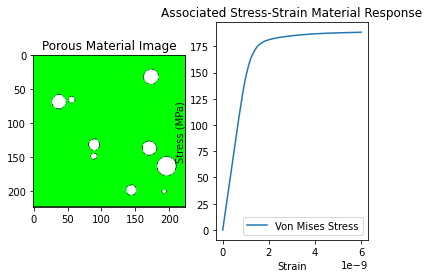

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 179.49078508237469 GPa


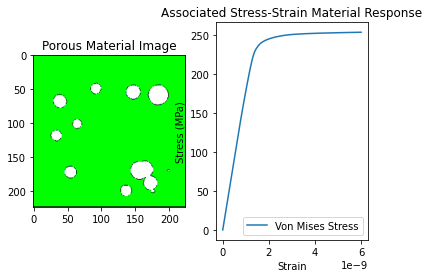

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 169.69061287201694 GPa


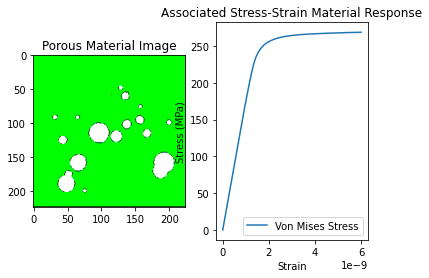

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 150.31095101472306 GPa


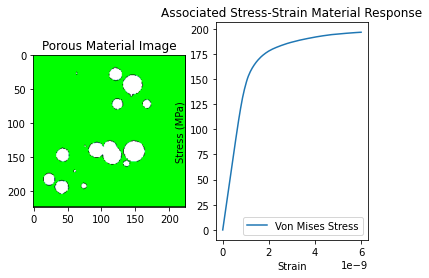

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 170.5813370439604 GPa


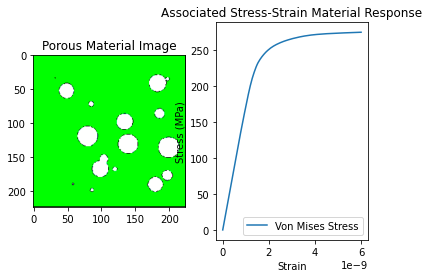

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 200.5507273616881 GPa


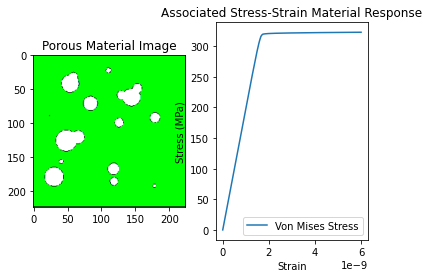

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 181.3384122413788 GPa


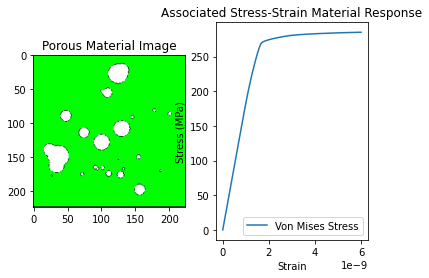

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 201.03217670560943 GPa


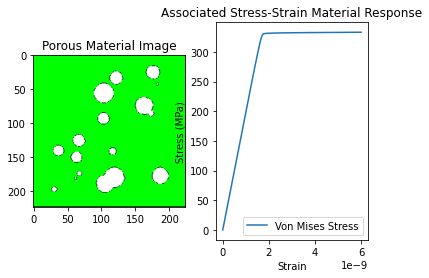

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 180.5603088308397 GPa


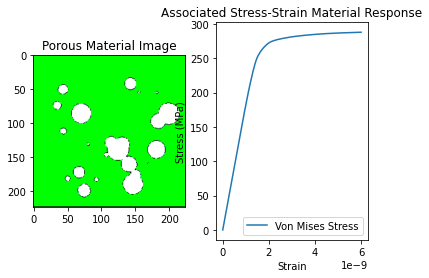

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 190.78767462299064 GPa


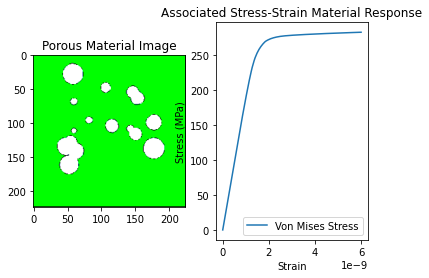

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 170.037565051806 GPa


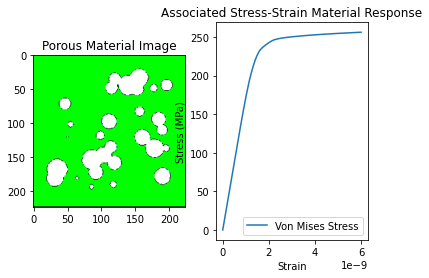

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 176.8088391561051 GPa


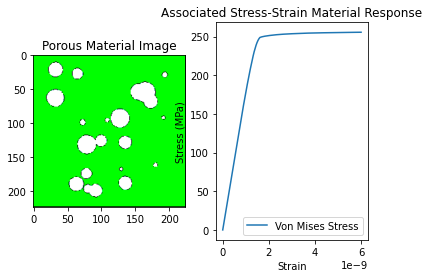

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 156.76167944128446 GPa


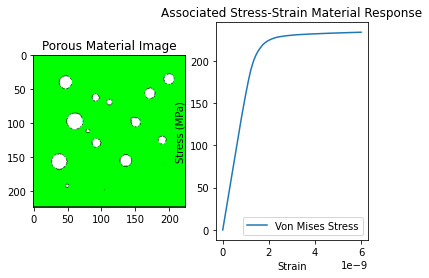

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 148.74569583185226 GPa


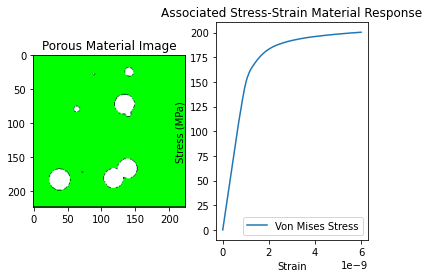

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 135.71710216857738 GPa


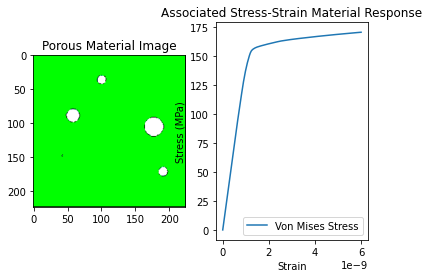

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 190.43598955986397 GPa


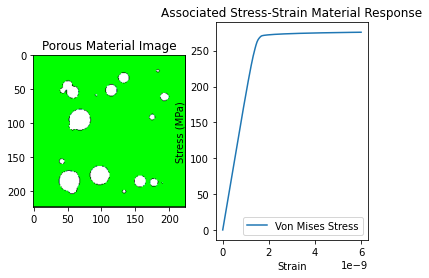

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 172.6917275091754 GPa


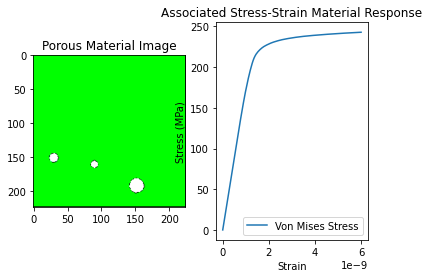

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 154.37976893569902 GPa


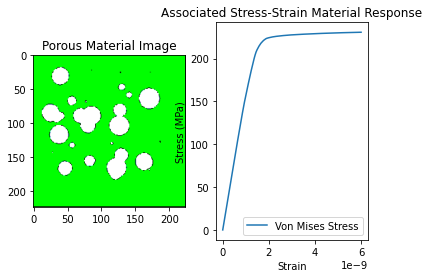

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 178.54913382731434 GPa


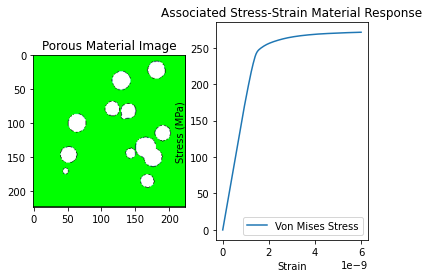

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 163.96413237720466 GPa


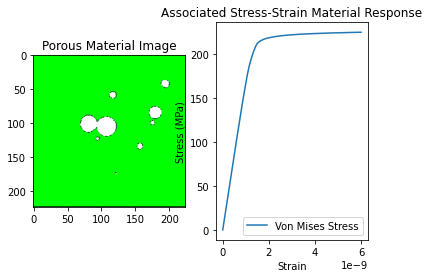

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 198.0107959704769 GPa


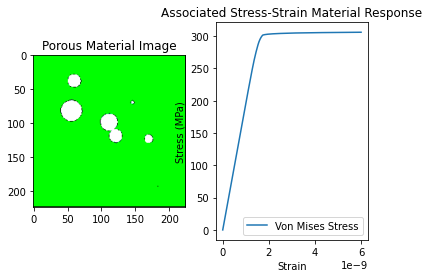

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 147.3894832047879 GPa


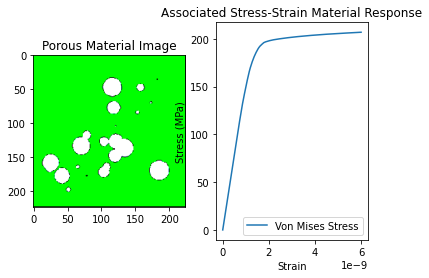

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 185.87153928366524 GPa


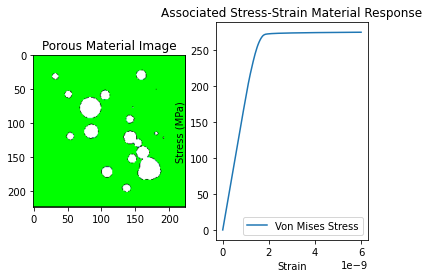

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 187.40513792248115 GPa


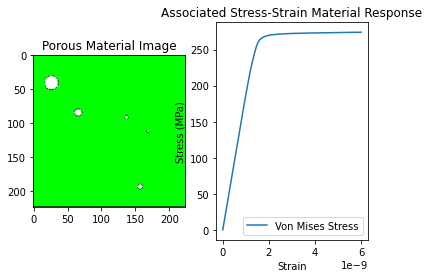

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 172.93516341499506 GPa


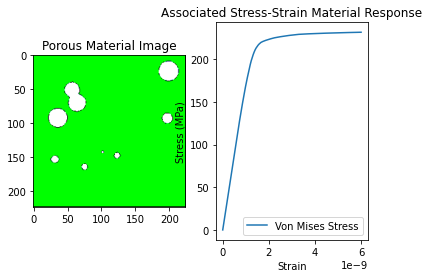

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 167.70383162108453 GPa


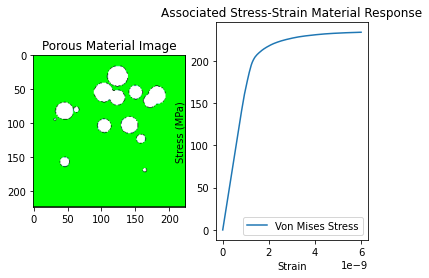

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 146.6876804917898 GPa


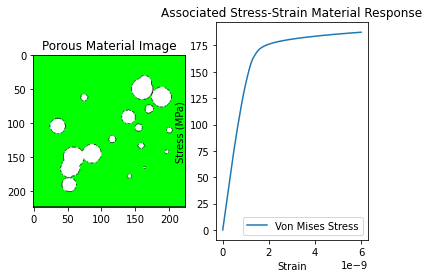

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 164.37179724537884 GPa


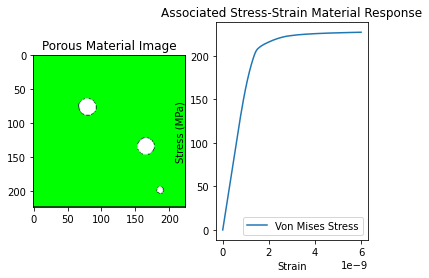

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 133.9087161602501 GPa


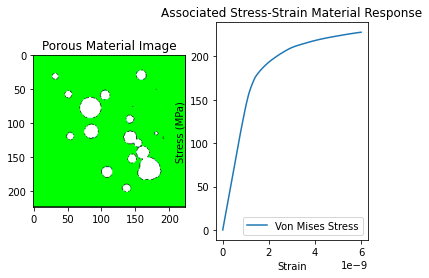

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 160.08922338270318 GPa


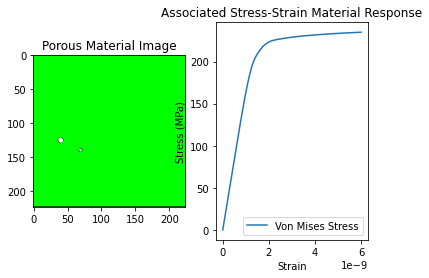

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 168.55809037203625 GPa


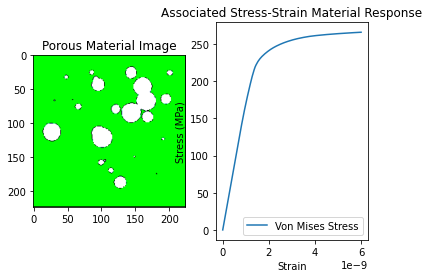

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 160.081564598535 GPa


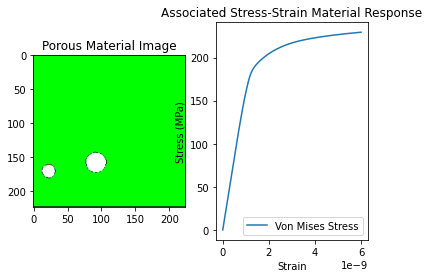

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 185.02666433395456 GPa


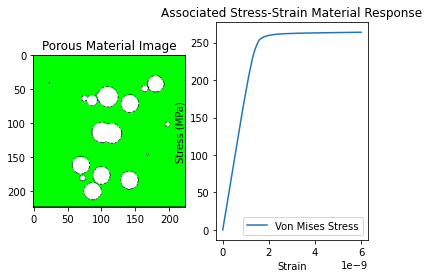

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 175.30544903314905 GPa


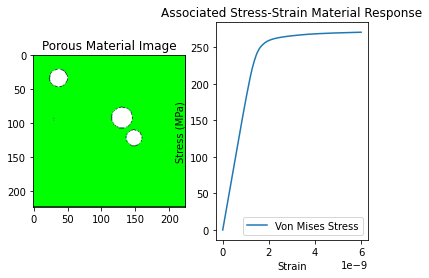

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 194.136047918706 GPa


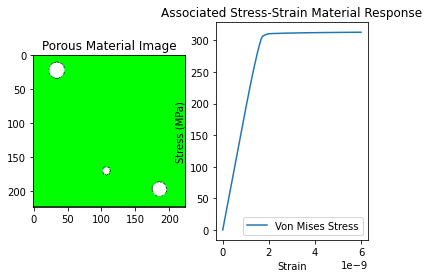

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 147.21566078925284 GPa


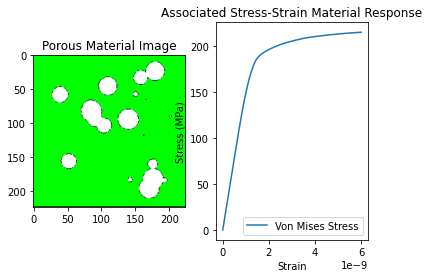

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 178.54913382731434 GPa


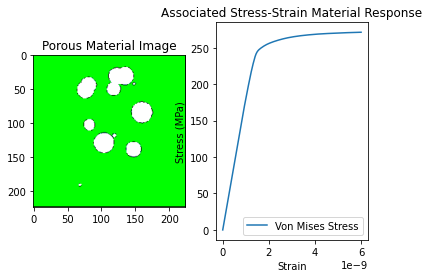

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 176.35472083991945 GPa


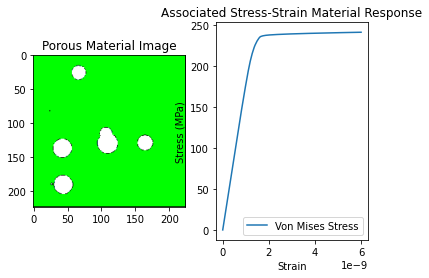

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Elastic Modulus = 192.35134548984095 GPa


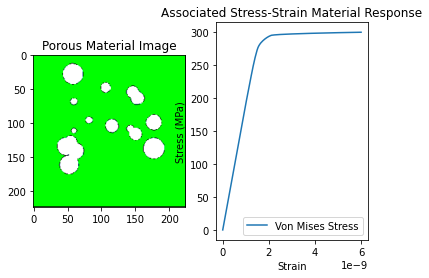

In [90]:
# Visualize train data of a random batch 
viz_batch_idx = random.randint(0, len(train_loader)-1)
for i, batch in enumerate(train_loader):
    if i != viz_batch_idx:
        continue
    og_image_batch, strain_batch, SMises_batch, E = batch
    for idx in range(len(og_image_batch)):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        print('Elastic Modulus = {0} GPa'.format(E[idx]))
        ax1.imshow(torch.movedim(og_image_batch[idx], 0, 2))
        ax1.set_title('Porous Material Image')
        ax2.plot(strain_batch[idx], SMises_batch[idx], label='Von Mises Stress')
        ax2.set_xlabel('Strain') 
        ax2.set_ylabel('Stress (MPa)')
        ax2.set_title('Associated Stress-Strain Material Response')
        ax2.legend()
        plt.show()
        print()


# Training

In [10]:
class PorousMaterialImageAndStrainToMaterialPropertiesNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv_net = models.squeezenet1_1(pretrained=False) # Nx3x224x224=>Nx1000
        self.conv_net = models.resnet50(pretrained=False) # Nx3x224x224=>Nx1000
        # self.conv_net = nn.Sequential(
        #     nn.Conv2d(3, 32, 3, bias=False),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, 5, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(6),
        #     nn.Conv2d(64, 1000, 5, bias=False),
        #     nn.BatchNorm2d(1000),
        #     nn.ReLU(),
        #     nn.MaxPool2d(32),
        #     nn.Flatten()
        # ) # Nx3x224x224=>Nx1000
        
        self.stresses_linear_net = nn.Sequential(
            nn.Linear(1000, 1), # *x1000 => *x1
        )
        self.E_linear_net = nn.Sequential(
            nn.Linear(2000, 1), # *x1000 => *x1
        )

        self.recurrent_net_model = nn.LSTM(input_size=1, hidden_size=1000, batch_first=True) # input:NxLxinput_size, h_0:1xNxhidden_size, c_0:1xNxhidden_size => output:NxLxhidden_size, h_n: 1xNxhidden_size, c_n:1xNxhidden_size

    def forward(self, og_images, strains):
        conv_out = self.conv_net(og_images) # Nx3x224x224=>Nx1000
        conv_out = torch.unsqueeze(conv_out, dim=0) # Nx1000 => 1xNx1000
        recurrent_out_tup = self.recurrent_net_model(torch.unsqueeze(strains, dim=2), (conv_out, conv_out)) #  input:NxL=>NxLx1, h_0:1xNx1000 c_0:1xNx1000 => NxLx1000, h_n: 1xNx1000, c_n:1xNx1000
        recurrent_output = recurrent_out_tup[0]
        h_output = torch.squeeze(recurrent_out_tup[1][0], dim=0) # 1xNx1000 => Nx1000
        c_output = torch.squeeze(recurrent_out_tup[1][1], dim=0) # 1xNx1000 => Nx1000
        recurrent_hidden_state_output = torch.cat([h_output, c_output], dim=1) # Nx1000 stack Nx1000 => Nx2000

        E = self.E_linear_net(recurrent_hidden_state_output) # Nx2000 => Nx1
        stresses = self.stresses_linear_net(recurrent_output) # NxLx1000 => NxLx1
        return torch.squeeze(stresses, dim=2), torch.squeeze(E, dim=1) # NxLx1 => NxL, Nx1 => N


In [11]:
def get_PorousMaterialImageAndStrainToMaterialPropertiesNet_accuracy(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    with torch.no_grad():
        for eval_batch in evaluation_dataloader:
            og_image_batch, strain_batch, SMises_batch, E_batch = eval_batch
            og_image_batch = og_image_batch.to(dtype=dtype, device=device)
            strain_batch = strain_batch.to(dtype=dtype, device=device)
            SMises_batch = SMises_batch.to(dtype=dtype, device=device)
            E_batch = E_batch.to(dtype=dtype, device=device)

            pred_SMises_batch, pred_E = model(og_image_batch, strain_batch)

            total_MSE += criterion(pred_SMises_batch, pred_E, SMises_batch, E_batch).cpu()
            num_vals += 1
    avg_MSE = total_MSE / num_vals
    return total_MSE, avg_MSE 

In [12]:
def porousMaterialImageAndStrainToMaterialPropertiesNet_criterion(pred_SMises, pred_E, SMises, E):
    SMises_loss = nn.functional.mse_loss(pred_SMises, SMises)
    E_loss = nn.functional.mse_loss(pred_E, E)
    return SMises_loss + E_loss

In [13]:
def porousMaterialImageAndStrainToMaterialPropertiesNetTrainingLoop(model, train_loader, val_loader, optimizer, criterion, model_checkpoint_save_dir, device, dtype):
    train_avg_MSE_vals = []
    val_avg_MSE_vals = []
    date_str = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    model_save_name = 'img_to_ss_model_{0}.pt'.format(date_str)
    model_save_path = '{0}{1}'.format(model_checkpoint_save_dir, model_save_name)
    model_training_info_name = 'model_{0}_training_info.pkl'.format(date_str)
    model_training_info_name_path = '{0}{1}'.format(model_checkpoint_save_dir, model_training_info_name)
    best_val_avg_MSE = 100000
    model = model.to(device=device)
    for e in range(nepochs):
        model.train() # Will put model in training mode
        print("Begin epoch {0}".format(e))
        for batch in train_loader:
            og_image_batch, strain_batch, SMises_batch, E_batch = batch
            og_image_batch = og_image_batch.to(dtype=dtype, device=device)
            strain_batch = strain_batch.to(dtype=dtype, device=device)
            SMises_batch = SMises_batch.to(dtype=dtype, device=device)
            E_batch = E_batch.to(dtype=dtype, device=device)
    
            pred_SMises_batch, pred_E_batch = model(og_image_batch, strain_batch)
            loss = criterion(pred_SMises_batch, pred_E_batch, SMises_batch, E_batch)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        _, current_train_avg_MSE = get_PorousMaterialImageAndStrainToMaterialPropertiesNet_accuracy(model, train_loader, criterion) # Will put model in eval mode
        _, current_val_avg_MSE = get_PorousMaterialImageAndStrainToMaterialPropertiesNet_accuracy(model, val_loader, criterion) # Will put model in eval mode
        train_avg_MSE_vals.append(current_train_avg_MSE)
        val_avg_MSE_vals.append(current_val_avg_MSE)
        if current_val_avg_MSE < best_val_avg_MSE:
            torch.save({
                'epoch':e,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'avg_train_loss':current_train_avg_MSE,
                'avg_val_loss':current_val_avg_MSE
            }, model_save_path)
            best_val_avg_MSE = current_val_avg_MSE
        print("Epoch {0}: train avg MSE={1}, val avg MSE={2}\n\n".format(e, current_train_avg_MSE, current_val_avg_MSE))
    with open(model_training_info_name_path, 'wb') as f:
        pickle.dump((train_avg_MSE_vals, val_avg_MSE_vals),f)
    return model_training_info_name_path, model_save_path
    

In [ ]:
model = PorousMaterialImageAndStrainToMaterialPropertiesNet()

learning_rate = 5e-3
nepochs = 60 
criterion = porousMaterialImageAndStrainToMaterialPropertiesNet_criterion
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_training_info_name_path, model_save_path = porousMaterialImageAndStrainToMaterialPropertiesNetTrainingLoop(model, train_loader, val_loader, optimizer, criterion, model_checkpoint_save_dir, device=device, dtype=dtype)
print("Training information saved as: {0}\nBest model data saved as: {1}".format(model_training_info_name_path, model_save_path))

Begin epoch 0
Epoch 0: train avg MSE=22903758258176.0, val avg MSE=25689961005056.0


Begin epoch 1
Epoch 1: train avg MSE=32834.87109375, val avg MSE=32189.82421875


Begin epoch 2
Epoch 2: train avg MSE=16632.9296875, val avg MSE=16119.484375


Begin epoch 3
Epoch 3: train avg MSE=10710.5556640625, val avg MSE=10338.7333984375


Begin epoch 4
Epoch 4: train avg MSE=6855.1962890625, val avg MSE=6612.64306640625


Begin epoch 5
Epoch 5: train avg MSE=4753.3466796875, val avg MSE=4578.62646484375


Begin epoch 6
Epoch 6: train avg MSE=4127.71435546875, val avg MSE=3967.731201171875


Begin epoch 7
Epoch 7: train avg MSE=2661.35546875, val avg MSE=2633.753173828125


Begin epoch 8
Epoch 8: train avg MSE=1812.532958984375, val avg MSE=1893.505126953125


Begin epoch 9
Epoch 9: train avg MSE=1646.723388671875, val avg MSE=1756.5953369140625


Begin epoch 10
Epoch 10: train avg MSE=1564.693115234375, val avg MSE=1706.992919921875


Begin epoch 11
Epoch 11: train avg MSE=1550.6087646484375, 

## Display Training Results

In [14]:
model_training_info_name_path = './models/checkpoints/model_12_11_2021_01_40_17_training_info.pkl'
model_save_path = './models/checkpoints/img_to_ss_model_12_11_2021_01_40_17.pt'

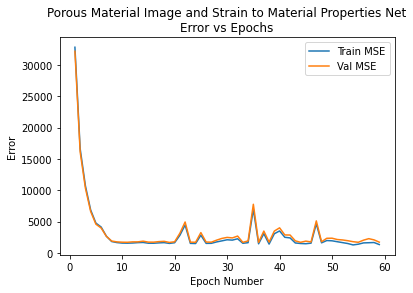

In [15]:
with open(model_training_info_name_path, 'rb') as f:
    train_avg_MSE_vals, val_avg_MSE_vals = pickle.load(f)
epoch_vals = np.arange(0, len(train_avg_MSE_vals))
cutoff_lower_bound = 1 

plt.figure()
plt.plot(epoch_vals[cutoff_lower_bound:], train_avg_MSE_vals[cutoff_lower_bound:], label='Train MSE')
plt.plot(epoch_vals[cutoff_lower_bound:], val_avg_MSE_vals[cutoff_lower_bound:], label='Val MSE')
plt.legend()
plt.title('Porous Material Image and Strain to Material Properties Net\nError vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Error')
plt.show()

In [16]:
best_model = PorousMaterialImageAndStrainToMaterialPropertiesNet()
best_checkpoint = torch.load(model_save_path)
criterion = porousMaterialImageAndStrainToMaterialPropertiesNet_criterion
best_epoch = best_checkpoint['epoch']
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_train_loss = best_checkpoint['avg_train_loss']
best_val_loss = best_checkpoint['avg_val_loss']

print('Best epoch = {0}, best train avg MSE loss = {1}, best val avg MSE loss = {2}'.format(best_epoch, best_train_loss, best_val_loss))

# best_optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate) # Should specify learning rate if wanting to load state of optimizer
# best_optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])

Best epoch = 19, best train avg MSE loss = 1513.860107421875, best val avg MSE loss = 1670.285888671875


## Test Results

In [17]:
def get_PorousMaterialImageAndStrainToMaterialPropertiesNet_random_output(model, evaluation_dataloader, num_random_batches=3, figsize=None):
    model.eval()
    model = model.to(device=device)
    batch_idxs = np.array([0])
    if (len(evaluation_dataloader)-1 > 0):
        batch_idxs = np.random.randint(0, high=len(evaluation_dataloader)-1, size=num_random_batches)
    with torch.no_grad():
        for i, eval_batch in enumerate(evaluation_dataloader):
            if i not in batch_idxs:
                continue
            og_image_batch, strain_batch, SMises_batch, E_batch = eval_batch
            og_image_batch = og_image_batch.to(dtype=dtype, device=device)
            strain_batch = strain_batch.to(dtype=dtype, device=device)

            pred_SMises_batch, pred_E_batch = model(og_image_batch, strain_batch)
            pred_SMises_batch = pred_SMises_batch.cpu()
            pred_E_batch = pred_E_batch.cpu()
            og_image_batch = og_image_batch.cpu()
            strain_batch = strain_batch.cpu()
            SMises_batch = SMises_batch.cpu()
            E_batch = E_batch.cpu()

            for idx in range(len(og_image_batch)):
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
                fig.tight_layout()

                ax1.imshow(torch.movedim(og_image_batch[idx], 0, 2))
                ax1.set_title('Porous Material Image')

                ax2.plot(strain_batch[idx], pred_SMises_batch[idx], label='Von Mises Stress')
                ax2.set_xlabel('Strain')
                ax2.set_ylabel('Stress (MPa)')
                ax2.set_title('Predicted Stress Response')
                ax2.legend()

                ax3.plot(strain_batch[idx], SMises_batch[idx], label='Von Mises Stress')
                ax3.set_xlabel('Strain')
                ax3.set_ylabel('Stress (MPa)')
                ax3.set_title('Ground Truth Stress Response')
                ax3.legend()

                fig.text(0, -0.1, 'Predicted E = {0} GPa\nGround Truth E = {1} GPa'.format(pred_E_batch[idx], E_batch[idx]))

                plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


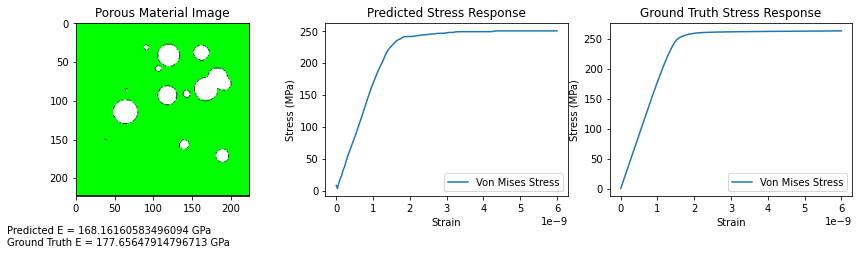

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


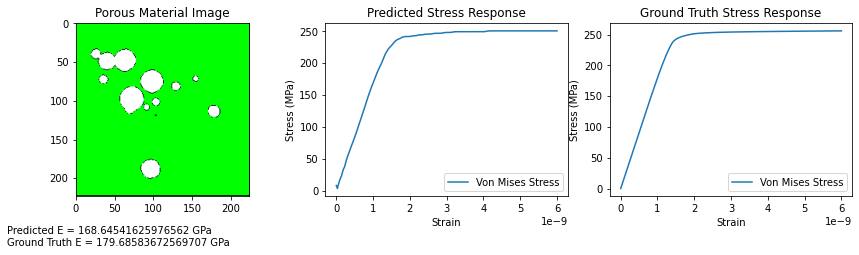

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


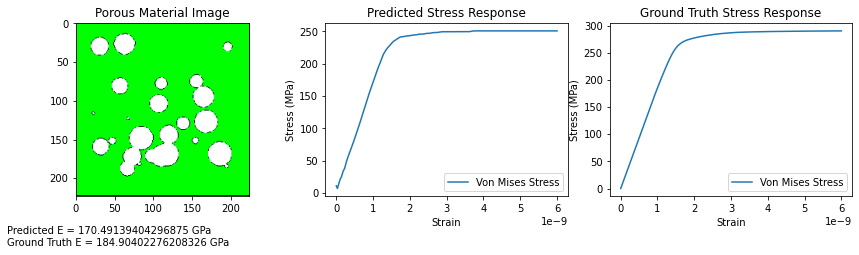

In [18]:
get_PorousMaterialImageAndStrainToMaterialPropertiesNet_random_output(best_model, test_loader, num_random_batches=3, figsize=(12,3))

In [19]:
test_total_MSE, test_avg_MSE = get_PorousMaterialImageAndStrainToMaterialPropertiesNet_accuracy(best_model, test_loader, criterion)
print('Best val set model: test total MSE = {0}(MPa+GPa)**2, test avg MSE = {1}(MPa+GPa)**2)'.format(test_total_MSE, test_avg_MSE))
print('Best val set model: test total sqrt(MSE) = {0}(MPa+GPa), test avg sqrt(MSE) = {1}(MPa+GPa)'.format(np.sqrt(test_total_MSE), np.sqrt(test_avg_MSE)))

Best val set model: test total MSE = 623111.3125(MPa+GPa)**2, test avg MSE = 1557.7783203125(MPa+GPa)**2)
Best val set model: test total sqrt(MSE) = 789.3740234375(MPa+GPa), test avg sqrt(MSE) = 39.46870040893555(MPa+GPa)


# Overfitting Data

In [14]:
overfit_train_size = 64 
overfit_val_size = 20
overfit_size = overfit_train_size+overfit_val_size 
overfit_dataset, _ = random_split(porous_train_dataset, (overfit_size, len(porous_train_dataset)-overfit_size))
overfit_train_dataset, overfit_val_dataset = random_split(overfit_dataset, (overfit_train_size, overfit_val_size))

In [15]:
overfit_train_loader = DataLoader(overfit_train_dataset, batch_size=overfit_train_size, shuffle=True)
overfit_val_loader = DataLoader(overfit_val_dataset)

In [ ]:
overfit_model = PorousMaterialImageAndStrainToMaterialPropertiesNet()

learning_rate = 5e-3
# learning_rate = 1e-3
nepochs = 600
criterion = porousMaterialImageAndStrainToMaterialPropertiesNet_criterion
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(overfit_model.parameters(), lr=learning_rate, weight_decay=0.1, momentum=0.9, dampening=0.99)

# Note used overfit loader as bost test and val set for this demonstration
overfit_model_training_info_name_path, overfit_model_save_path = porousMaterialImageAndStrainToMaterialPropertiesNetTrainingLoop(overfit_model, overfit_train_loader, overfit_val_loader, optimizer, criterion, model_checkpoint_save_dir, device=device, dtype=dtype)
print("Training information saved as: {0}\nBest model data saved as: {1}".format(overfit_model_training_info_name_path, overfit_model_save_path))

Begin epoch 0
Epoch 0: train avg MSE=73596.984375, val avg MSE=77337.0859375


Begin epoch 1
Epoch 1: train avg MSE=241900592.0, val avg MSE=241180592.0


Begin epoch 2
Epoch 2: train avg MSE=67556.1875, val avg MSE=71166.046875


Begin epoch 3
Epoch 3: train avg MSE=73396.265625, val avg MSE=77117.3203125


Begin epoch 4
Epoch 4: train avg MSE=65066.0234375, val avg MSE=68569.140625


Begin epoch 5
Epoch 5: train avg MSE=3860578304.0, val avg MSE=3903819264.0


Begin epoch 6
Epoch 6: train avg MSE=24691311902720.0, val avg MSE=24940076072960.0


Begin epoch 7
Epoch 7: train avg MSE=4170937498861568.0, val avg MSE=4197182970265600.0


Begin epoch 8
Epoch 8: train avg MSE=5.334991479242752e+16, val avg MSE=5.264593529287475e+16


Begin epoch 9
Epoch 9: train avg MSE=7.355531785351987e+16, val avg MSE=6.993982297368166e+16


Begin epoch 10
Epoch 10: train avg MSE=1147225224773632.0, val avg MSE=1060069668028416.0


Begin epoch 11
Epoch 11: train avg MSE=2500736319488.0, val avg MSE=22383

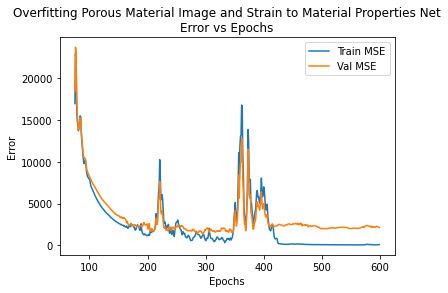

In [24]:
with open(overfit_model_training_info_name_path, 'rb') as f:
    overfit_train_avg_MSE_vals, overfit_val_avg_MSE_vals = pickle.load(f)
plt.figure()
epoch_vals = np.arange(0, len(overfit_train_avg_MSE_vals))
cutoff_lower_bound = 75
plt.plot(epoch_vals[cutoff_lower_bound:], overfit_train_avg_MSE_vals[cutoff_lower_bound:], label='Train MSE')
plt.plot(epoch_vals[cutoff_lower_bound:], overfit_val_avg_MSE_vals[cutoff_lower_bound:], label='Val MSE')
plt.legend()
plt.title('Overfitting Porous Material Image and Strain to Material Properties Net\nError vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [103]:
# Best overfitting model will just be final model
overfit_best_model = overfit_model

In [104]:
# Visualize train results
get_PorousMaterialImageAndStrainToMaterialPropertiesNet_random_output(overfit_best_model, overfit_train_loader, num_random_batches=1, figsize=(12,3))

Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


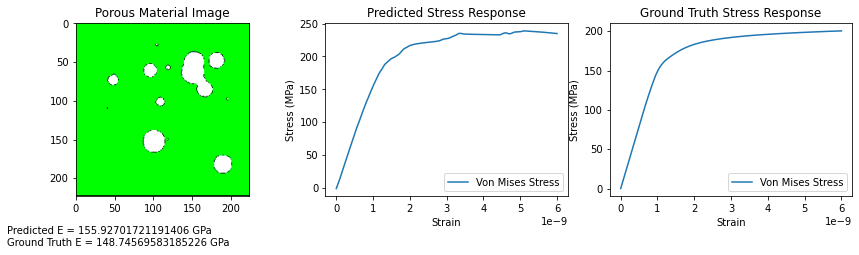

In [105]:
# Visualize val results
get_PorousMaterialImageAndStrainToMaterialPropertiesNet_random_output(overfit_best_model, overfit_val_loader, num_random_batches=1, figsize=(12,3))